# Inference of hierarchical Gaussian model parameters

In [1]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pints
import scipy.stats
import seaborn as sns
sns.set_theme()

The data-generating distribution is
$$
    y \sim p(\cdot | \mu _{\mathrm{pop}}) =
    \int \mathrm{d}\mu \, \mathcal{N}(y | \mu, 1)\,
    \mathcal{N}(\mu | \mu _{\mathrm{pop}}, 1)
$$

Due to the conjugacy of Gaussian distributions, the hierarchical distribution
can be computed exactly to be

$$
    y \sim \mathcal{N}(\cdot | \mu _{\mathrm{pop}}, 2).
$$

Together with
a Gaussian prior $\mu _{\mathrm{pop}} \sim \mathcal{N}(\cdot | \mu _0 = 0, \sigma _0^2 = 16)$, we
can also use the conjugacy to compute the posterior
distribution analytically
$$
    p(\mu _{\mathrm{pop}} | \mathcal{D}) =
        \mathcal{N}(\mu _{\mathrm{pop}} | \mu ', \sigma '^2 ),
$$
where
$$
    \mu' = \sigma '^2\frac{n\bar{y}}{2},
    \quad
    \sigma '^2 = \frac{16}{1 + 8n}.
$$
Here, $n$ is the number of snapshot observations in the dataset
$\mathcal{D}=\{y_j^{\mathrm{obs}}\}$ and $\bar{y}$ denotes the empirical mean,
$\bar{y} = \sum _j y_j^{\mathrm{obs}} / n$.

# Synthesise data

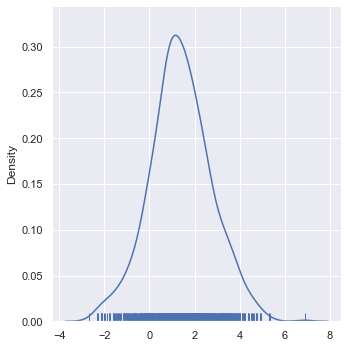

In [25]:
np.random.seed(42)
n_ids = 1000
n_samples_per_id = 1
true_parameters = [1.3, 1, 1]  # pop mean, pop std., noise
means = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids)
data = np.empty(shape=(n_ids, n_samples_per_id))
for ids, mean in enumerate(means):
    data[ids] = np.random.normal(
    loc=mean, scale=true_parameters[2], size=n_samples_per_id)

sns.displot(data.flatten(), kind='kde', rug=True)
plt.show()

## Define log-likelihoods

1. Exact Gaussian log-likelihood
2. Gaussian filter log-likelihood
3. KDE filter log-likelihood

In [75]:
class ExactHierarchicalLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations
        self._n_ids, self._n_obs = observations.shape
        self._error_model = chi.GaussianErrorModel()
        self._pop_model = chi.GaussianModel()

    def __call__(self, parameters):
        # Compute population contribution
        means = parameters[:self._n_ids]
        pop_mean = parameters[self._n_ids]
        pop_sigma, sigma = [1, 1]
        score = np.sum(
            scipy.stats.norm(loc=pop_mean, scale=pop_sigma).logpdf(
                means))
        if np.isinf(score):
            return score

        # Compute contributions from individual log-likelihoods
        for _id, mean in enumerate(means):
            score += np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations[_id]))

        return score

    def evaluateS1(self, parameters):
        # Compute population contribution
        means = np.array(parameters[:self._n_ids])
        pop_mean = parameters[self._n_ids]
        pop_sigma, sigma = [1, 1]
        score, pop_sens = self._pop_model.compute_sensitivities(
            parameters=[pop_mean, pop_sigma], observations=means)

        # Compute individual contributions
        sensitivities = np.zeros(self.n_parameters())
        for _id, indiv_obs in enumerate(self._observations):
            s, sens = self._error_model.compute_sensitivities(
                parameters=[sigma],
                model_output=np.array([means[_id]] * self._n_obs),
                model_sensitivities=np.ones(shape=(self._n_obs, 1)),
                observations=indiv_obs)

            score += s
            sensitivities[_id] += sens[0]

        # Add population sensitivities
        sensitivities += pop_sens[:-1]

        return score, sensitivities

    def n_parameters(self):
        return self._n_ids + 1

    def get_parameter_names(self):
        return ['Mean'] * self._n_ids + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_ids)] + [None]


class GaussianFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = np.array(observations).flatten()
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        standard_mean_samples = np.array(
            parameters[:self._n_samples])[:, np.newaxis]
        standard_noise_samples = np.array(
            parameters[self._n_samples:2*self._n_samples])[np.newaxis, :]
        pop_mean = parameters[-1]
        pop_std, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mean + standard_mean_samples * pop_std
        measurements = mean_samples + sigma * standard_noise_samples

        # Estimate population mean and population std from samples
        pop_mu = np.mean(measurements)
        pop_sigma = np.std(measurements, ddof=1)
        score = np.sum(
            scipy.stats.norm(loc=pop_mu, scale=pop_sigma).logpdf(
                self._observations))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = pop_sigma / self._n_samples
        dpop_mu_hat_depsilon = sigma / self._n_samples
        dpop_mu_hat_dpop_mu = 1
        dpop_mu_hat_dpop_sigma = np.mean(eta)
        dpop_sigma_hat_deta = \
            pop_sigma * (measurements - pop_mu_hat) / (self._n_samples - 1) \
            / pop_sigma_hat
        dpop_sigma_hat_depsilon = \
            sigma * (measurements - pop_mu_hat) / (self._n_samples - 1) / \
            pop_sigma_hat
        dpop_sigma_hat_dpop_mu = 0

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu,
            dpop_mu_hat_dpop_sigma]), shape=(n_obs, 4))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[0] + sens[-1] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[1] + sens[-1] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[2] + sens[-1] * dpop_sigma_hat_dpop_mu

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return [
            'Mean eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class GaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = self._n_samples ** (-0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute mean measurements and kernel sizes
        # (use conjugacy of Gaussian error model and Gaussian kernel)
        mean_samples = pop_mu + eta * pop_sigma
        measurements = mean_samples + sigma * epsilon

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        # p = log mean exp scores
        # dp/dmean = exp(score) / sum(exp(scores)) * dscore / dmean
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        # dp/dpop_mean = exp(score) / sum(exp(scores)) * dscore / dpop_mean
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - pop_sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax,
                axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax,
                axis=0)
        sensitivities[2*self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax)

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return ['Mean eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]

## Inference

### 1. Exact likelihood

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.3
1     6      0.25     1        0:00.4
2     7      0.25     1        0:00.5
3     8      0.25     1        0:00.5
20    2002   0.748    111      2:08.9
40    4334   0.741    112      4:45.9
60    6625   0.782633 110      7:15.3
80    7981   0.731    65       8:40.5
100   9763   0.775    85      10:32.3
120   10155  0.727    19      10:56.9
140   10535  0.739    19      11:20.8
160   10903  0.725    18      11:44.0
180   11299  0.752    19      12:08.8
200   11695  0.762    19      12:33.6
220   12059  0.748    18      12:56.4
240   12399  0.768    17      13:17.6
260   12701  0.721    15      13:36.5
280   13097  0.754    19      14:01.1
300   13429  0.749    16      14:22.2
320   13729  0.755    15      14:41.0
340   14013  0.751    14      14:59.3
360   14297  0.75     14      15:16.8
380   14685  0.754    19      15:41.1
400   15033  0.756

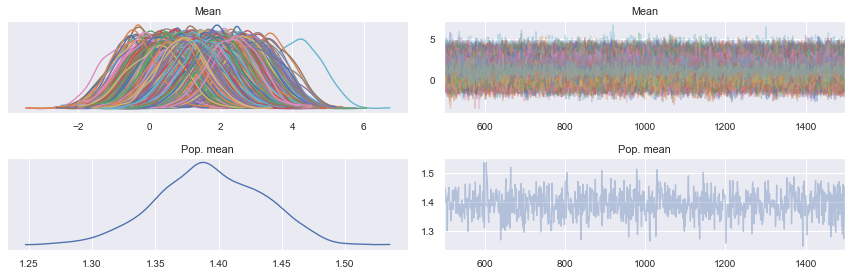

In [40]:
n_ids = 1000
log_likelihood = ExactHierarchicalLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-20, 20)] * n_ids + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
controller._initial_params[0, 0, :n_ids] = means
controller._initial_params[0, 0, -1] = 1
n_iterations = 1500
exact_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    exact_posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

In [42]:
exact_posterior_samples.to_netcdf(
    'derived_data/posteriors/hierarchical_gaussian_model_exact.nc')

### 2. Gaussian filter likelihood

10 samples

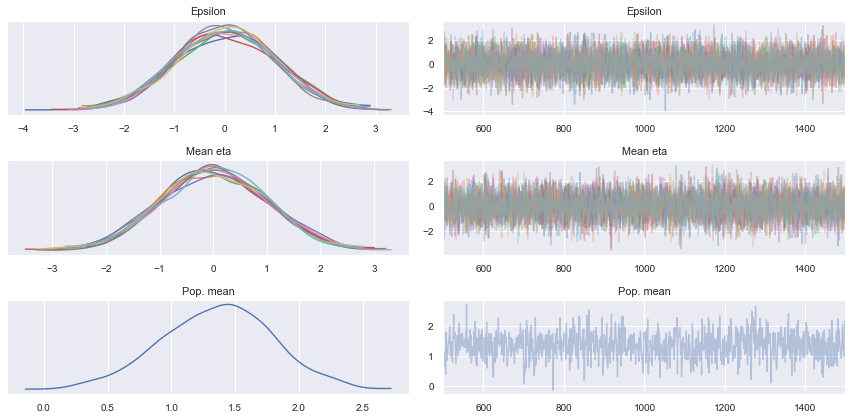

In [53]:
n_samples = 10
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations)

warmup=500
az.plot_trace(
    gaussian_filter_10_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

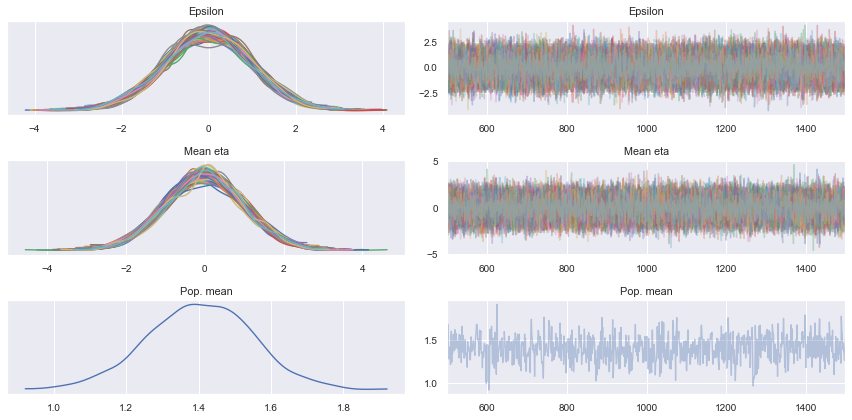

In [55]:
n_samples = 100
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations)

warmup=500
az.plot_trace(
    gaussian_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

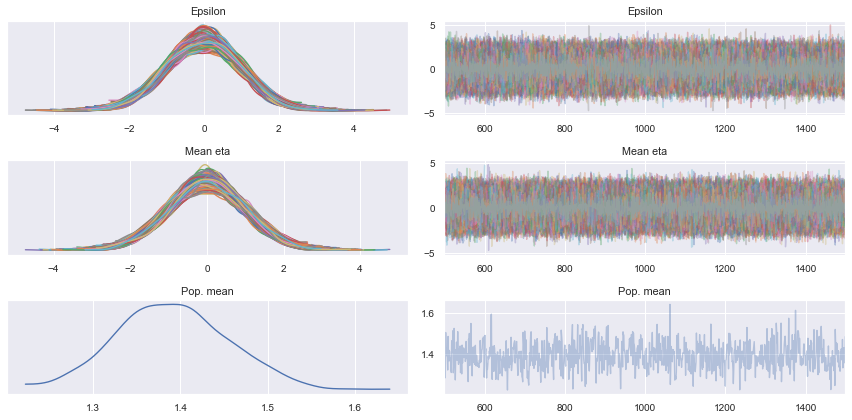

In [56]:
n_samples = 1000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations)

warmup=500
az.plot_trace(
    gaussian_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

10000 samples

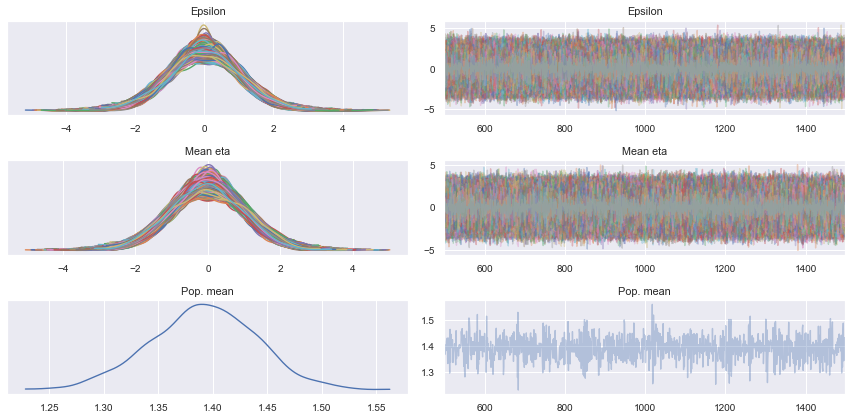

In [62]:
n_samples = 10000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10000_posterior_samples = controller.run(
    n_iterations=n_iterations)

warmup=500
az.plot_trace(
    gaussian_filter_10000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [63]:
gaussian_filter_10000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_gaussian_model_gaussian_filter_10000.nc')

### 3. Gaussian KDE filter likelihood

10 samples

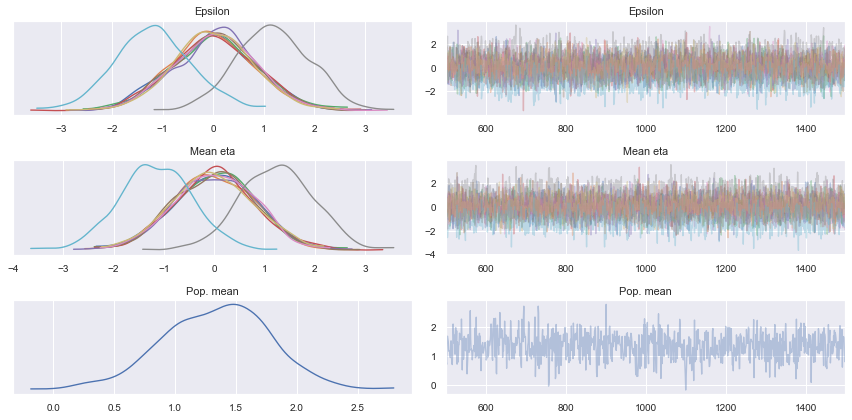

In [77]:
n_samples = 10
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    gaussian_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


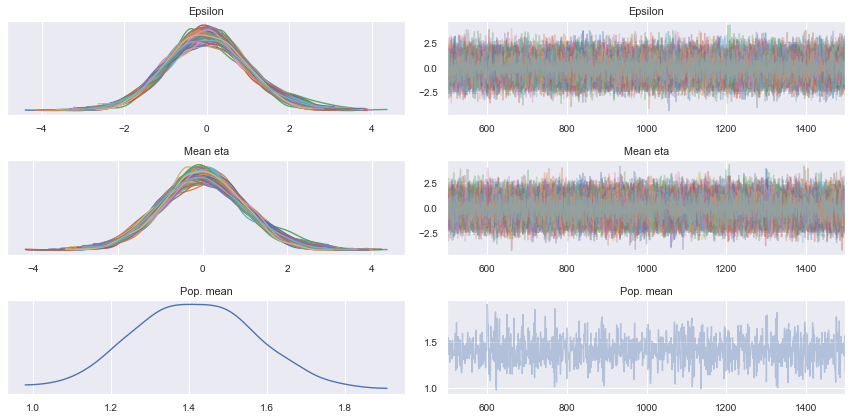

In [78]:
n_samples = 100
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    gaussian_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

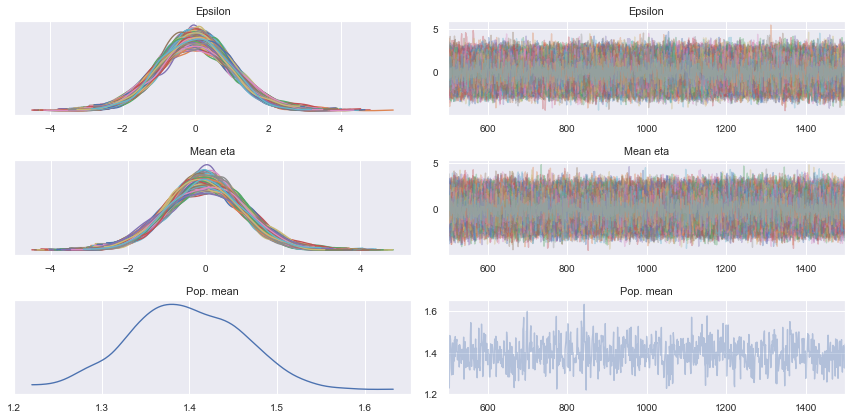

In [80]:
n_samples = 1000
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=500
az.plot_trace(
    gaussian_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [81]:
gaussian_kde_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_gaussian_model_gaussian_kde_filter_1000.nc')

## Comparison to analytic posterior

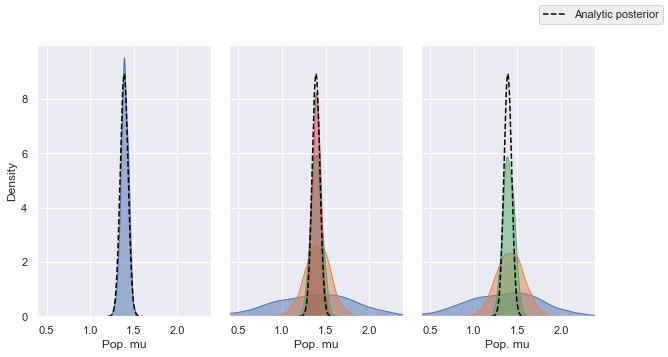

In [82]:
# Get true distribution
n = len(data)
posterior_var = 16 / (1 + n * 8)
posterior_mean = posterior_var * n * np.mean(data) / 2
mus = np.linspace(1.2, 1.6, num=200)
true_pdf = scipy.stats.norm(posterior_mean, np.sqrt(posterior_var)).pdf(mus)

# Create figure
fig, axes = plt.subplots(
    1, 3, figsize=(10, 5), sharey='row', sharex='row')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
axes[0].set_xlim([posterior_mean - 1, posterior_mean + 1])
axes[0].set_xlabel('Pop. mu')
axes[1].set_xlabel('Pop. mu')
axes[2].set_xlabel('Pop. mu')
colors = sns.color_palette()

# Plot exact likelihood inference
warmup = 500
thinning = 1
mu_samples = exact_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[0],
    palette=colors[0], legend=False)

# Plot Gaussian filter posteriors
warmup = 1000
thinning = 1
mu_samples = gaussian_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[2], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_filter_10000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[3], legend=False)

# Plot KDE filter posteriors
warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
    palette=colors[1], legend=False)

# Overlay exact posterior
axes[0].plot(
    mus, true_pdf, color='black', linestyle='--', label='Analytic posterior')
axes[1].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[2].plot(
    mus, true_pdf, color='black', linestyle='--')

fig.legend()
plt.show()